<a href="https://colab.research.google.com/github/gackouhamady/MLSD-25-26-Courses/blob/main/01-Data-Engineering/BI%20/notebooks/05_Classification_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification**

$\underline{Classification~problem~~types}$ :
- Is an email an attempt at pishing?
- Is a customer likely to churn?
- Is the web user likely to click on an advertisement?
- $⇒$ typical *supervised* learning issues

$\underline{Objective}$ : Predict whether a record is a $1$ or a $0$ (pishing/not-pishing, click/don't click, churn/don(t churn), or one of several categories (filtering inbox into 'primary', 'social' etc...)

$\underline{Output}$ : a binary classification, and in many cases a probability score or propensity of belonging to the class of interest.

In [ ]:
if (!require(klaR)) install.packages('klaR')
if (!require(MASS)) install.packages('MASS')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(FNN)) install.packages('FNN')
if (!require(mgcv)) install.packages('mgcv')
if (!require(rpart)) install.packages('rpart')

In [ ]:
library(klaR)
library(MASS)
library(ggplot2)
library(FNN)
library(mgcv)
library(rpart)

# Naive Bayes

## The naive solution

$\underline{Procedure}$ :
1. For a binary response $Y=i$ ($i=0$ or $1$), estimate the $\color{red}{individual~conditional~probabilities}$ for each predictor $P(X_j \vert Y=i)$; these are the probabilities that the predictor value is in the record when we observe the $Y=i$. This probability is estimated by the proportion of $X_j$ values among the $Y=i$ records in the training set.
2. Multiply these probabilities by each other, and then by the $\color{green}{proportion~of~records~belonging~to~Y=i}$.
3. Repeat steps 1 and 2 for all the classes.
4. Estimate the probability outcome $i$ by taking the value calculated in step $2$ for class $i$ and dividing it by the $\color{blue}{sum~of~such~values~for~all~classes}$.
5. Assign the record to the class with the highest probability for this set of predictor values.

$\underline{Formally}$ :
\begin{equation}
P(Y=i \vert X_1,X_2,...,X_p)=\frac{P(Y=i)P(X_1,...,X_p \vert Y=i)}{P(Y=0)P(X_1,...,X_p \vert Y=0)+P(Y=1)P(X_1,...,X_p \vert Y=1)}
\end{equation}

Under the naive Bayes assumption of conditional independence:

\begin{equation}
P(Y=i \vert X_1,X_2,...,X_p)=\frac{\color{green}{P(Y=i)}\color{red}{P(X_1 \vert Y=i)}...\color{red}{P(X_p \vert Y=i)}}
{\color{blue}{P(Y=0)P(X_1 \vert Y=0)...P(X_p \vert Y=0)}+\color{blue}{P(Y=1)P(X_1 \vert Y=1)...P(X_p \vert Y=1)}}
\end{equation}
<br>

Why *naive*?: We assume that $X_j$ is *independent* of all the other predictor variables $X_k$ for $k \neq j$.



In [ ]:
# Load the data
loan_data <- read.csv(file.path('sample_data', 'loan_data.csv.gz'), stringsAsFactors = TRUE)
head(loan_data)

In [ ]:
# Set 'default' to be level 1 of factor outcome
loan_data$outcome <- ordered(loan_data$outcome, levels = c("paid off", "default"))
levels(loan_data$outcome)

[1] "paid off" "default"

In [ ]:
# We fit a model to the loan payment data using the klaR package
naive_model <- NaiveBayes(outcome ~ purpose_ + home_ + emp_len_,
                          data = na.omit(loan_data))
print("----------------------------")
print("---- NB model: Conditional probabilities ----")
print("----------------------------")
naive_model$table


[1] "----------------------------"
[1] "---- NB model: Conditional probabilities ----"
[1] "----------------------------"


$purpose_
          var
grouping   credit_card debt_consolidation home_improvement major_purchase
  paid off  0.18759649         0.55215915       0.07150104     0.05359270
  default   0.15151515         0.57571347       0.05981209     0.03727229
          var
grouping      medical      other small_business
  paid off 0.01424728 0.09990737     0.02099599
  default  0.01433549 0.11561025     0.04574126

$home_
          var
grouping    MORTGAGE       OWN      RENT
  paid off 0.4894800 0.0808963 0.4296237
  default  0.4313440 0.0832782 0.4853778

$emp_len_
          var
grouping     < 1 Year   > 1 Year
  paid off 0.03105289 0.96894711
  default  0.04728508 0.95271492


In [ ]:
# We make a prediction for a given loan
new_loan <- loan_data[147, c('purpose_', 'home_', 'emp_len_')]
row.names(new_loan) <- NULL
new_loan
print("----------------------------")
print("\n---- NB model: one loan prediction ----")
print("----------------------------")
predict(naive_model, new_loan)

# NB:
# We get a posterior estimate of the probability of default.

purpose_,home_,emp_len_
<fct>,<fct>,<fct>
small_business,MORTGAGE,> 1 Year


[1] "----------------------------"
[1] "\n---- NB model: one loan prediction ----"
[1] "----------------------------"


paid off,default
0.3463013,0.6536987


**Caution** : The Bayesian Classifier works only with categorical predictors. To apply naive Bayes to numerical predictors, you can:
- bin and convert the numerical predictors to categorical predictors and apply the algorithm.
- or, use a probability model -- for example, the normal distribution -- to estimate the conditional probability $P(X_j \vert Y = i)$.

# Discriminant Analysis

The most commonly used is *Linear Discriminant Analysis* (LDA).  

NB: *Discriminant analysis assumes that predictor variables are normally distributed continuous variables. In practice, the method works well even for not extreme departures from normality, and for binary predictors.*

## Covariance Matrix

The covariance measures the relationship between two variable, $x$ and $z$ (for $n$ records):
\begin{equation}
s_{x, z}=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(z_i-\bar{z})}{n-1}
\end{equation}

Positive values indicate a positive relationship, and conversly for negative values. The covariance scale depends on the scale of the variables.<br>

The *covariance matrix*, $\Sigma$, for $x$ and $z$ consists of the individual variable variances, $s^2_x$ and $s^2_z$, on the diagonal and the covariances between pairs on the off-diagonals:

\begin{bmatrix}
s^2_x & s_{x, z}\\
s_{z, x} & s^2_z
\end{bmatrix}

## Fisher's Linear Discriminant

Fisher's linear discriminant distinguishes variation *between* groups  from variation *within* groups. More formally, LDA maximizes the *between* sum of squares $SS_{between}$ relative to the *within* sum of squares $SS_{within}$.

- $SS_{between}$: distance between the two group means
- $SS_{within}$: spread around the means within each group

Let us suppose that we want to predict a binary outcome $y$ ($0$ or $1$) using two continuous numeric variables $(x, z)$. The method finds the linear combination, $w_x x+w_z z$ that maximizes the sum of squares ratio $\frac{SS_{between}}{SS_{within}}$.

In [ ]:
# Load the data
loan3000 <- read.csv(file.path('sample_data', 'loan3000.csv'), stringsAsFactors=TRUE)

# Set 'default' to be level 1 of factor outcome
loan3000$outcome <- ordered(loan3000$outcome, levels = c("paid off", "default"))
levels(loan3000$outcome)

# In the following code, we use two predictor variables and obtain
# the estimated linear discriminator weights, wx and wz.
loan_lda <- lda(outcome ~ borrower_score + payment_inc_ratio, data=loan3000)
loan_lda$scaling

# NB:
# It the predictor variables are normalized prior to running LDA, the discriminator
# weights are measures of variable importance, thus providing a computationally
# efficient method for feature selection.

[1] "paid off" "default"

,LD1
borrower_score,-7.17583880
payment_inc_ratio,0.09967559


In [ ]:
# Let us predict the probability of "default" versus "paid off"
pred <- predict(loan_lda)
print(head(pred$posterior))

   paid off   default
1 0.4464563 0.5535437
2 0.4410466 0.5589534
3 0.7273038 0.2726962
4 0.4937462 0.5062538
5 0.3900475 0.6099525
6 0.5892594 0.4107406


Warning message:
“Removed 18 rows containing missing values (geom_point).”


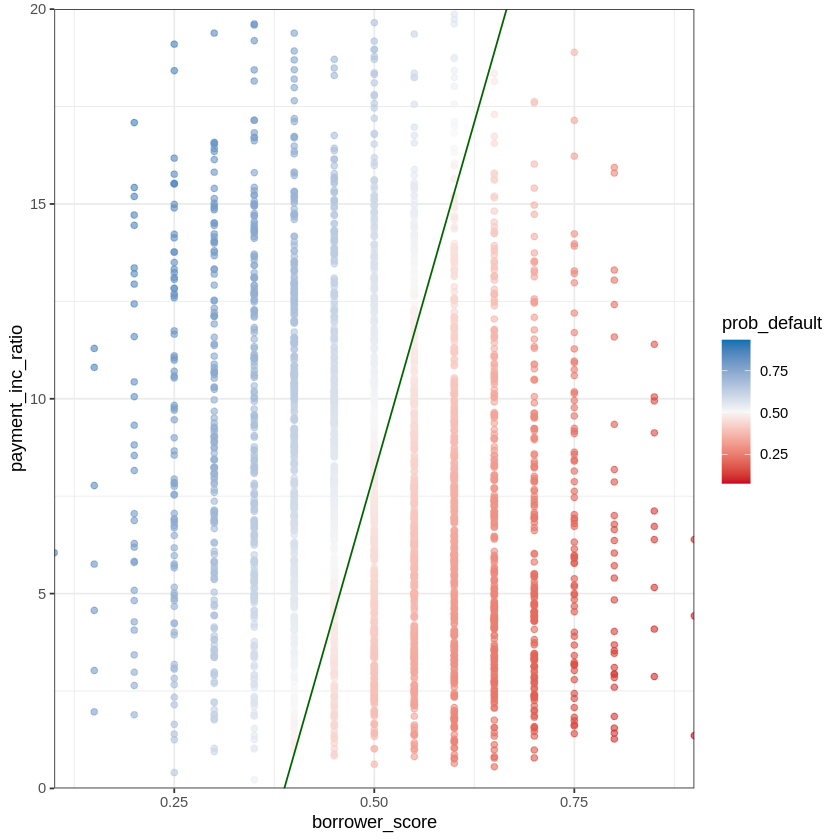

In [ ]:
# We can illustrate the LDA with a plot of the probabilities in the 2D
# predictor space. We also plot the separator line (wx.x + wz.z)

# Compute the predictions
pred <- predict(loan_lda)
lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

# Compute the LDA linear separator equation
center <- 0.5 * (loan_lda$mean[1, ] + loan_lda$mean[2, ])
slope <- -loan_lda$scaling[1] / loan_lda$scaling[2]
intercept = center[2] - center[1] * slope

# Plot the LDA probablities
graph <- ggplot(data=lda_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) +
  geom_point(alpha=.6) +
  scale_color_gradientn(colors=c('#ca0020', '#f7f7f7', '#0571b0')) +
  scale_x_continuous(expand=c(0,0)) +
  scale_y_continuous(expand=c(0,0), lim=c(0, 20)) +
  geom_abline(slope=slope, intercept=intercept, color='darkgreen') +
  theme_bw()

graph

# NB:
# Data points on the left of the diagonal line are predicted to default
# (probility greater than 0.5). LDA splits the predictor space into two regions.
# The predictions far away from the separator have higher level of confidence.

# Logistic Regression

TBD

# Evaluating Classification models

$\underline{Accuracy}$ : The proportion of cases classified correctly.

$\underline{Confusion~matrix}$ : A tabular display ( $2 \times 2$ in the binary case) of the record counts by their predicted and actual classification status.

$\underline{Sensitivity}$ : The proportion of all $1s$ that are correctly classified as $1s$ (aka, *Recall*).

$\underline{Specificity}$ : The proportion of all $0s$ that are correctly classified as $0s$.

$\underline{Precision}$ : The proportion of predicted $1s$ that are actually $1s$.

$\underline{ROC~curve}$ : A plot of sensitivity versus specificity.

$\underline{Lift}$ : A measure of how effective the model is at identifying (comparatively rare) $1s$ at different probability cutoffs.

## Confusion Matrix

It is a table showing the number of correct and incorrect predictions categorized by type of response




In [ ]:
# We fit a Logistic Regression with Generalized Additive Models on the loan data.
# Y = 1: event 'loan default'
# Y = 0: event 'loan paid off'
logistic_gam <- gam(outcome ~ s(payment_inc_ratio) + purpose_ +
                      home_ + emp_len_ + s(borrower_score),
                    data=loan_data, family='binomial')
logistic_gam


Family: binomial 
Link function: logit 

Formula:
outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + 
    s(borrower_score)

Estimated degrees of freedom:
7.66 4.17  total = 21.83 

UBRE score: 0.2681506     

In [ ]:
# Build the confusion matrix

# Predict the outcome probability from the model
pred <- predict(logistic_gam, newdata=loan_data)
print("Pred. probability"); head(pred)

# Get the corresponding class (0 < : 'paid off' | 0 > : 'default' )
pred_y = as.numeric(pred > 0)
print("Pred. class"); head(pred_y, n = 20)

# Get the outcome true values
true_y <- as.numeric(loan_data$outcome=='default')
print("True class"); head(true_y, n = 20)

# Compute the true positive
true_pos <- (true_y==1) & (pred_y==1)
# Compute the true negative
true_neg <- (true_y==0) & (pred_y==0)
# Compute the false positive
false_pos <- (true_y==0) & (pred_y==1)
# Compute the true negative
false_neg <- (true_y==1) & (pred_y==0)

conf_mat <- matrix(c(sum(true_pos), sum(false_pos),
                     sum(false_neg), sum(true_neg)), 2, 2)
colnames(conf_mat) <- c('Yhat = 1', 'Yhat = 0')
rownames(conf_mat) <- c('Y = 1', 'Y = 0')
conf_mat

# NB:
# In the confusion matrix, the predicted outcomes are columns and the true outcomes
# are the rows.The diagonal show the number of incorrect predictions.

[1] "Pred. probability"


1           2           3           4           5           6 
-1.08721693 -0.88629367  0.08067709  0.46144919 -0.15833583  0.45875292

[1] "Pred. class"


[1] 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1

[1] "True class"


[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

,Yhat = 1,Yhat = 0
Y = 1,14293,8378
Y = 0,8051,14620


In [ ]:
# Deduce the evaluation metrics

# precision (TP / (TP + FP))
conf_mat[1, 1] / sum(conf_mat[,1])
# recall (TP / (TP + FN))
conf_mat[1, 1] / sum(conf_mat[1,])
# specificity (TN / (TN + FP)) --> NB: increasing FP increases specificity
conf_mat[2, 2] / sum(conf_mat[2,])

[1] 0.6396796

[1] 0.630453

[1] 0.6448767

**About the rare class problem**

In a rare class problem, the minority class is of interest. For instance, legitimate insurance claims ($0$) versus fraudulent ones ($1$), or browsers ($0$) versus purchasers ($1$) at website. Misclassifying the $1s$ as $0s$ is costlier than misclassifying the $0s$ as $1s$. Indeed, correctly identifying a fraudulent insurance claim may save thousands of dollars.

In such case we would be happier with a model that has a high recall, even if the false positive rate is high.

# ROC Curve

There is a trade-off between *recall* and *specificity*. The metric that captures this trade-off is the *Receiver Operating Characteristics* curve (ROC curve). It plots recall (sensitivity) on the $y$-axis against specificity on the $x$-axis. The ROC curve shows the trade-off between the recall and specificity as you change the cutoff to determine how th classify a record.

**Computing the ROC curve**
1. Sort the record by the predicted probability of being a 1, starting with the most probable and ending with the least probable.
2. Compute the cumulative specificity and recall based on the sorted records.

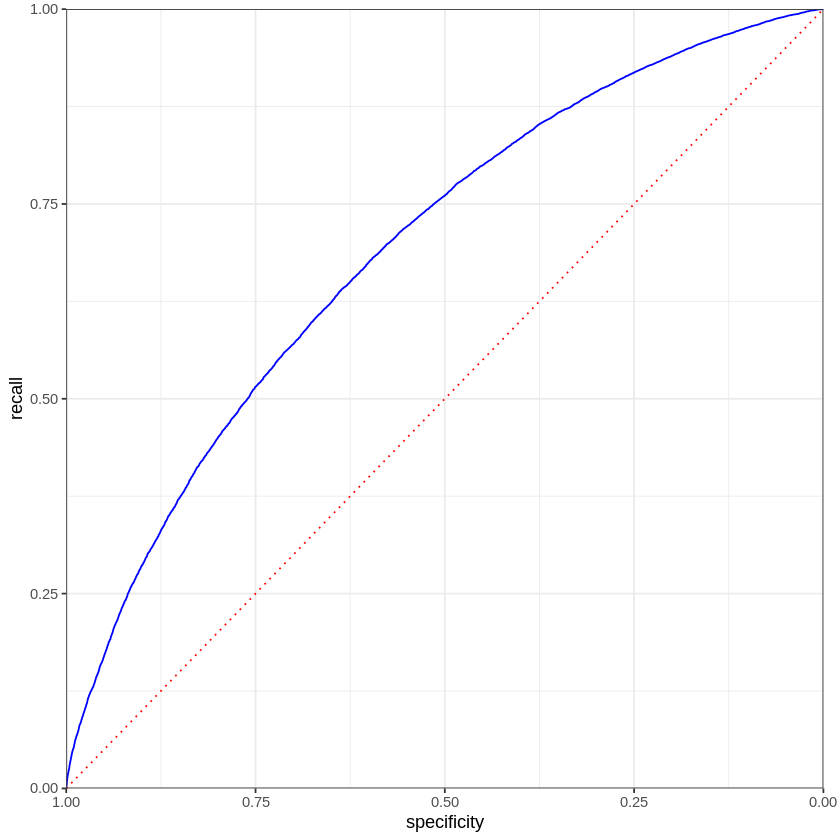

In [ ]:
# Order the probabilities
idx <- order(-pred)
# Compute cumulative recall and specificity
recall <- cumsum(true_y[idx] == 1) / sum(true_y == 1)
specificity <- (sum(true_y == 0) - cumsum(true_y[idx] == 0)) / sum(true_y == 0)
roc_df <- data.frame(recall = recall, specificity = specificity)

# Plot the metrics
graph <- ggplot(roc_df, aes(x=specificity, y=recall)) +
  geom_line(color='blue') +
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) +
  geom_line(data=data.frame(x=(0:100) / 100), aes(x=x, y=1-x),
            linetype='dotted', color='red') +
  theme_bw() + theme(plot.margin=unit(c(5.5, 10, 5.5, 5.5), "points"))
graph

# NB:
# Dotted line = classifier no better than random chance
# Effective classifier = a ROC that hugs the upper left corner, identifying
# many 1s while avoiding to misclassify many 0s
#
# Example: If you want a classifier with a specificity of at least 50%,
# then the recall is about 75%.

**The AUC metric**

The AUC metric corresponds to the area underneath the curve metric. Hence, we can produce a single measure from a ROC curve with the AUC. The larger the value of AUC, the more effective the classifier. An AUC of $1$ indicates a perfect classifier, while a completely ineffective classifier -- the digonal line -- will have an AUC of $0.5$.

In [ ]:
# The AUC can be computed by a numerical integration
sum(roc_df$recall[-1] * diff(1-roc_df$specificity))
head(roc_df)

# NB:
# The model has an AUC of about $0.69$, corresponding to a relatively
# weak classifier.

[1] 0.6926232

,recall,specificity
,<dbl>,<dbl>
1,4.410921e-05,1.0000000
2,8.821843e-05,1.0000000
3,8.821843e-05,0.9999559
4,1.323276e-04,0.9999559
5,1.764369e-04,0.9999559
6,2.205461e-04,0.9999559


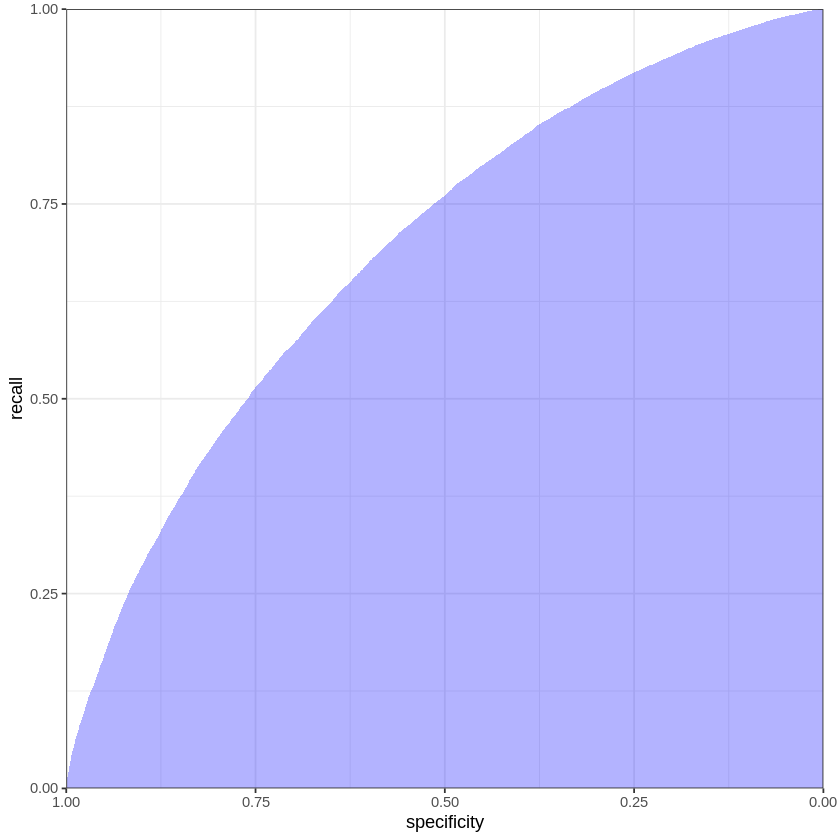

In [ ]:
# Illustrating the AUC value
graph <- ggplot(roc_df, aes(specificity)) +
  geom_ribbon(aes(ymin=0, ymax=recall), fill='blue', alpha=.3) +
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) +
  labs(y='recall') +
  theme_bw() + theme(plot.margin=unit(c(5.5, 10, 5.5, 5.5), "points"))
graph

# Strategies for imbalanced data

Imbalanced data are data in which the outcome of interest (eg. purchase on a website, insurance fraud) is rare. Several strategies can be applied to improve the predictive modeling performance with imbalanced data.

$\underline{Undersample}$ : Use fewer of the prevalent class records in the classification model.

$\underline{Oversample}$ : Use more of the rare class records in the classification model, bootstrapping if necessary.

$\underline{Up~weigh~or~down~weight}$ : Attach more (or less) weight to the rare (or prevalent) class in the model.

$\underline{Datageneration}$ : Like boot

**Undersampling**

If you have enough data, one solution is to *undersample* the prevalent class, so that the data to be modeled is more balanced between $0s$ and $1s$. The assumption is that the dominant class has many redundant records.

In [ ]:
# We load the imbalanced full_train_set data
full_train_set <- read.csv(file.path('sample_data', 'full_train_set.csv.gz'), stringsAsFactors=TRUE)

# Set 'default' to be level 1 of factor outcome
full_train_set$outcome <- ordered(full_train_set$outcome, levels = c("paid off", "default"))
levels(full_train_set$outcome)

[1] "paid off" "default"

In [ ]:
# For the full_train_set data set, 19% of the loans were in 'default'.
mean(full_train_set$outcome=='default')

[1] 0.1889455

In [ ]:
# Let us try to model the model on the full data set
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ +
                            emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, family='binomial')

# Predict
pred <- predict(full_model)

# The percentage of predicted 1s (minority class)
mean(pred > 0)
mean(full_train_set$outcome=='default') / mean(pred > 0)

# NB:
# Only 0.39% of the loans are predicted to be in 'default', or less than 1/47
# of the expected number. In fact, due to the desequilibrium, the model is more
# likely to find some nondefault loans that it is similar to, by chance.
#
# Remember: when a balanced sample was used, roughly 50% of the loans were
# predicted to be in 'default'.

[1] 0.003942094

[1] 47.93023

**Oversampling and Up/Down Weighting**

The undersampling is throwing away data, which is an issue when you have a small data set. Another solution is to oversample the rarer class by drawing additional rows with replacement (bootstrapping).

We can achieve a similar effect by weighting the data. Many classification algorithms take a weight argument that will allow youto up/down weight the data.

In [ ]:
# Create the weight vector
wt <- ifelse(full_train_set$outcome=='default',
             1 / mean(full_train_set$outcome == 'default'), 1)

# Fit a GLM model
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ +
                  home_ + emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, weight=wt, family='quasibinomial')

# Predict outcomes
pred <- predict(full_model)

# Compute the percent of 'default'
mean(pred > 0)

# NB:
# The weight for loans that default are set to be 1/p where p is the
# probability of 'default'. The 'paid off' have a weight of 1. Hence,
# the sum of the weights for the 'default' and 'paid off' are roughly
# equal. As a results, the mean predicted 1s reaches now 58%.

[1] 0.5767208